# BERTopic for detractors

In [1]:
# Importing necessary libraries/packages
import numpy as np
import pandas as pd
import scipy as scs
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
import os
import datetime as dt
import re

import gensim
from gensim.utils import simple_preprocess
import nltk

import gensim.corpora as corpora
from pprint import pprint

#import pyLDAvis.gensim_models
import pickle 
#import pyLDAvis

pd.set_option("display.max_columns", 50, "display.max_rows", 100)

# Authentication
from google.colab import auth
auth.authenticate_user()

#Importing data from bigquery
from google.cloud import bigquery
proj_name = 'pg-duke-student-capstone-v1'
proj_num = '545682952716'
proj_id =   'pg-duke-student-capstone-v1'
client = bigquery.Client(project=proj_id)

!pip install contractions
### Importing necessary libraries
import pandas as pd
import nltk
import string
#stopwords
from nltk.corpus import stopwords
#tokenizer
from nltk.tokenize import RegexpTokenizer
#lemmatizer
from nltk.stem import WordNetLemmatizer
#Stemmer
from nltk.stem.porter import PorterStemmer

#contractions
import contractions

#gensims
import gensim
from gensim import models
from gensim.utils import simple_preprocess
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

!pip install bertopic
from bertopic import BERTopic
!pip install joblib==1.1.0

from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic import BERTopic


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.7 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 23.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 80.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     

Load Data

In [2]:
# Reading data from big query

sql_query_csat = ('''SELECT *
                FROM pg-duke-student-capstone-v1.final_merged.clean_nps
                ''')

# Run a Standard SQL query with the project set explicitly
project_id = 'pg-duke-student-capstone-v1'
#data = pd.read_gbq(sql, project_id=project_id, dialect='standard')
data = pd.read_gbq(sql_query_csat, project_id=proj_id, dialect='standard')
data.head()



,int64_field_0,application_id,product_type,respondent_id,survey_key,created_at,score,zendesk_ticket_id,medium,verbatim,analytics_user_id,analytics_user_id_1,gender,state_code,individual_income,age,marketing_application_source,first_touch_device,bmi,num_conditions,history_of_tobacco_use,marital_status,segment,segment_description
0,905,1273719.0,homeandauto,962841204,KEv4iDf9fOwFkrqGJ3dG78E3FXmoEjs5,2021-10-04 14:04:10+00:00,10,None,None,Listen to problems,1ae9467c575a4697bd99382cb7901979,1ae9467c575a4697bd99382cb7901979,male,None,NaN,77.0,Direct,Desktop,NaN,0.0,<NA>,divorced,NaN,None
1,1380,428727.0,homeandauto,669663712,a9CaYMZQJ6YAxihgHTyWSD1DhpTxGb9I,2020-07-24 14:09:47+00:00,8,None,None,My experience with Policy genius was great and...,6dfe7167d4c741cca83826dc5b22c580,6dfe7167d4c741cca83826dc5b22c580,female,None,NaN,37.0,Direct,Desktop,NaN,0.0,<NA>,None,NaN,None
2,1389,841048.0,homeandauto,850431113,o9BFKWnnOducRd4AjQcETyjbHbTj0xQb,2021-04-02 16:57:16+00:00,9,None,None,Working with you was fast and easy and I like ...,2f359d6cde594f309b0989e96ce2454f,2f359d6cde594f309b0989e96ce2454f,male,WI,NaN,56.0,Direct,Desktop,NaN,0.0,<NA>,single,NaN,None
3,1398,1454888.0,homeandauto,1047155544,BHUlqVZW1c5am64nlz3rXnnJop68iqXS,2022-01-06 13:03:58+00:00,10,None,None,My agent was very informed and help make the p...,052feaa8c2a14c94953481e4c0567dd3,052feaa8c2a14c94953481e4c0567dd3,male,CA,NaN,28.0,Direct,Desktop,NaN,0.0,<NA>,married,NaN,None
4,1419,1544133.0,homeandauto,1075912288,qSi8fsNFAjS3atrE54cmsd52Mec8gsmP,2022-02-17 11:47:16+00:00,10,None,None,I got my insurance for both vehicles cut in ha...,653fc046465e40dc8b3b0f73a17bdcfd,653fc046465e40dc8b3b0f73a17bdcfd,male,LA,NaN,35.0,Direct,Desktop,NaN,0.0,<NA>,married,NaN,None


# Pre-processing

Create Data time variables and separated the data into detractors, passives, and promoters

In [3]:
data = data.dropna(subset=["verbatim"], axis=0)

data['date'] = pd.to_datetime(data['created_at'])
data['day'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

data["score_categorized"] = pd.cut(data.score, bins=[-np.inf, 6, 8, 10],
                  labels=["detractor", "passive", "promoter"])

det = data[data['score_categorized'] == 'detractor']
det["year-month"] =det.year.astype(str) + "-" + det.month.astype(str)
det_nps = det["verbatim"].tolist()
det_nps_1 = "".join(det_nps)
det["verbatim_len"] = det["verbatim"].apply(lambda x : len(x.split()))
det_arr = np.array(det["verbatim"])

years = [2017, 2018, 2019, 2020, 2021, 2022]
for year in years:
   globals()[f'det_{year}'] = det[det['year'] == year]



Preprocessing steps including normalizing, tokenising, removing stopwords, punctuations etc

In [4]:
#DATA PREPROCESSING STEPS
### Removing stopwords, tokenizing data, lemmaziting, converting to lower case, remove panctuations, i 

stop_words = stopwords.words('english')

stop_words.extend(['from', 'subject', 'use', 'policygenius', 'policy', 'genius','insurance', "pg", 'none', 'na', "able", "already", "also",
                   "was", "were", "thus", "although", "always", "bc", "because", "definitely", "could", "couldnt", 'would', "wouldnt"])

def preprocess(text_col):
    """This function will apply NLP preprocessing lambda functions over a pandas series such as df['text'].
       These functions include converting text to lowercase, removing emojis, expanding contractions, removing punctuation,
       removing numbers, removing stopwords, lemmatization, etc."""
    
    # convert to lowercase
    text_col = text_col.apply(lambda x: ' '.join([w.lower() for w in x.split('/')]))
    
    # remove emojis
    #text_col = text_col.apply(lambda x: demoji.replace(x, ""))
    
    # expand contractions  
    text_col = text_col.apply(lambda x: ' '.join([contractions.fix(word) for word in x.split()]))

    # remove punctuation
    text_col = text_col.apply(lambda x: ''.join([i for i in x if i not in string.punctuation]))
    
    # remove numbers
    text_col = text_col.apply(lambda x: ' '.join(re.sub("[^a-zA-Z]+", " ", x).split()))

    # remove stopwords
    stopwords = [sw for sw in stop_words if sw not in ['not', 'no']]
    text_col = text_col.apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))

    # lemmatization
    from nltk.stem import WordNetLemmatizer
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    text_col = text_col.apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(w) for w in x.split()]))

    # stemming
    #from nltk.stem import PorterStemmer
    #text_col = text_col.apply(lambda x: ' '.join([PorterStemmer().stem(w) for w in x.split()]))

    # remove short words
    text_col = text_col.apply(lambda x: ' '.join([w.strip() for w in x.split() if len(w.strip()) >= 3]))

    return text_col

Preprocessing the detractors dataset

In [5]:
det_clean = preprocess(det["verbatim"])  #[3] # L + stemming

det_clean = preprocess(det["verbatim"])  #[3] # L + stemming
det_clean1 = np.array(det_clean)   
# det_clean1


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Modelling + Fine-tuning

Fine-tuning each step of Bertopic

In [46]:
## Defining the different steps the Bertopic algorithm uses to process and analyse the data

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(random_state=1832,n_neighbors=40, n_components=8, min_dist=0.0, metric='cosine') # n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine'

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=40, min_samples=1, metric='euclidean', cluster_selection_method='eom', prediction_data = True) # min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True

# Step 4 - Tokenize topics and create ngrams
vectorizer_model = CountVectorizer(stop_words="english", ngram_range= (2, 3))

# Step 5 - Create topic representation 
ctfidf_model = ClassTfidfTransformer()

In [47]:
# Putting All steps together nr_topics=7

topic_model_detra = BERTopic(nr_topics= 6, 
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=umap_model,              # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model, verbose = True)          # Step 5 - Extract topic words
  #diversity=0.8)                       # Step 6 - Diversify topic words)

topics, probs = topic_model_detra.fit_transform(det_clean1)


Batches:   0%|          | 0/28 [00:00<?, ?it/s]

2023-04-13 01:05:46,036 - BERTopic - Transformed documents to Embeddings
2023-04-13 01:05:51,036 - BERTopic - Reduced dimensionality
2023-04-13 01:05:51,087 - BERTopic - Clustered reduced embeddings
2023-04-13 01:05:54,267 - BERTopic - Reduced number of topics from 10 to 6


In [48]:
from bertopic import BERTopic
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

#topic_model = BERTopic(verbose=True, n_gram_range=(1, 3))
#topics, _ = topic_model.fit_transform(docs)

# Preprocess Documents
documents = pd.DataFrame({"Document": det_clean1,
                          "ID": range(len(det_clean1)),
                          "Topic": topics})
documents_per_topic = documents.groupby(['Topic'], as_index=False).agg({'Document':' '.join})
cleaned_docs = topic_model_detra._preprocess_text(documents_per_topic.Document.values)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model_detra.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model_detra.get_topic(topic)] 
               for topic in range(len(set(topics))-1)]

# Removing any empty strings
topic_words = [[x for x in sub_arr if x not in ('', None)] for sub_arr in topic_words]
topic_words


# Evaluate
coherence_model = CoherenceModel(topics=topic_words, 
                                 texts=tokens, 
                                 corpus=corpus,
                                 dictionary=dictionary, 
                                 coherence='c_v')
coherence = coherence_model.get_coherence()
print(coherence)

0.6202549099827539


In [49]:
topic_model_detra.get_topic_info()


,Topic,Count,Name
0,-1,229,-1_took month_customer service_process took_fe...
1,0,235,0_took month_process took_medical record_way long
2,1,180,1_customer service_felt like_bait switch_custo...
3,2,141,2_text email_phone email_email text_email phone
4,3,49,3_lack communication_response communication_sl...
5,4,46,4_took month_half birthday_account debited_pay...


In [89]:
# topic_model_detra.save('/content/det_model')

In [50]:
words_df = pd.DataFrame({'topics': topics, 'doc_cleaned': det_clean1, 'doc_raw': det['verbatim']})

In [56]:
words_df[words_df['topics'] == 4]

,topics,doc_cleaned,doc_raw
74,4,turned coverage,You turned me down for coverage
255,4,fairly simple process sign not allow much cove...,It was a fairly simple process to sign up for ...
311,4,completely botching start date application pay...,completely botching up the start date of my ap...
441,4,requested clear wanted oneyear longterm disabi...,I requested and was very clear that I wanted a...
2267,4,application insurer website long call answer l...,Most of the application was on the insurers we...
2345,4,found process drawn think gone directly insure...,We found the process very drawn out. I think I...
2433,4,went month without coverageno communication un...,I went 6 months without coverageNo communicati...
2529,4,found experience relatively painfree cannot re...,While I found the experience relatively pain-f...
2585,4,seems communication insuring company still not...,There seems to be no communication between you...
3062,4,happy process except not read paid agent spoke...,I’m happy with my policy and the process. Exce...


Reduces outliers

In [10]:
new_topics = topic_model_detra.reduce_outliers(det_clean1, topics, probabilities=probs)


100%|██████████| 1/1 [00:00<00:00, 17.64it/s]


Creating a table consisting of detractor key themes and raw comments for Tableau dashboard

In [11]:
tbl1 = pd.DataFrame({'topic': new_topics, 'doc_cleaned': det_clean1, 'raw comment': det["verbatim"], 
                            'year': det['year'],
                            'year-month': det['year-month']})

In [12]:
tbl1.topic.value_counts()


 0    302
 1    228
 2    185
 3     60
 4     57
-1     48
Name: topic, dtype: int64

In [13]:
doc_info = topic_model_detra.get_document_info(det_clean1)
doc_info.head()

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,web site faulty not update progress correctly ...,-1,-1_took month_customer service_process took_fe...,took month - customer service - process took -...,0.0,False
1,ask question over secure web site difficult ac...,-1,-1_took month_customer service_process took_fe...,took month - customer service - process took -...,0.0,False
2,first time heard need little time recommend fa...,1,1_customer service_felt like_bait switch_custo...,customer service - felt like - bait switch - c...,1.0,False
3,turned coverage,4,4_took month_half birthday_account debited_pay...,took month - half birthday - account debited -...,1.0,False
4,friend family,1,1_customer service_felt like_bait switch_custo...,customer service - felt like - bait switch - c...,1.0,False


In [18]:
topic_model_detra.get_topic_info()


,Topic,Count,Name
0,-1,229,-1_took month_customer service_process took_fe...
1,0,235,0_took month_process took_medical record_way long
2,1,180,1_customer service_felt like_bait switch_custo...
3,2,141,2_text email_phone email_email text_email phone
4,3,49,3_lack communication_response communication_sl...
5,4,46,4_took month_half birthday_account debited_pay...


In [30]:
doc_info[doc_info['Topic'] == 4]['Top_n_words'].value_counts()

took month - half birthday - account debited - payment info - month finalize - fault company - pay higher - payment date - interim coverage - coverage took    46
Name: Top_n_words, dtype: int64

In [14]:
det_tbl = pd.DataFrame({'comment': det.verbatim, 
                            'group': det.score_categorized, 
                            'topic': new_topics, 
                            'top_n_words': doc_info.Top_n_words.values,
                            'date': det.date})

In [15]:
det_tbl.head()

,comment,group,topic,top_n_words,date
27,Web site faulty didn't update with progress co...,detractor,1,took month - customer service - process took -...,2017-05-23 15:56:31+00:00
31,You ask the the same questions overs and over....,detractor,1,took month - customer service - process took -...,2022-04-01 12:03:30+00:00
64,"First time i heard about Policygenius, need a ...",detractor,1,customer service - felt like - bait switch - c...,2020-11-03 16:50:35+00:00
74,You turned me down for coverage,detractor,4,took month - half birthday - account debited -...,2020-11-12 14:23:14+00:00
84,I have no friends or family,detractor,1,customer service - felt like - bait switch - c...,2021-11-18 17:33:55+00:00


In [32]:
det_tbl[det_tbl['topic'] == 1]

,comment,group,topic,top_n_words,date
27,Web site faulty didn't update with progress co...,detractor,1,customer service - felt like - bait switch - c...,2017-05-23 15:56:31+00:00
31,You ask the the same questions overs and over....,detractor,1,customer service - felt like - bait switch - c...,2022-04-01 12:03:30+00:00
64,"First time i heard about Policygenius, need a ...",detractor,1,customer service - felt like - bait switch - c...,2020-11-03 16:50:35+00:00
84,I have no friends or family,detractor,1,customer service - felt like - bait switch - c...,2021-11-18 17:33:55+00:00
117,It’s ok,detractor,1,customer service - felt like - bait switch - c...,2022-03-26 11:13:22+00:00
...,...,...,...,...,...
13023,Didn't like getting bounced around to differen...,detractor,1,customer service - felt like - bait switch - c...,2021-10-14 11:46:15+00:00
13076,I had 4 different “agents” minor of whom took ...,detractor,1,customer service - felt like - bait switch - c...,2018-06-04 09:06:05+00:00
13127,"Given the overall timeline, buying life insura...",detractor,1,customer service - felt like - bait switch - c...,2020-09-28 10:51:36+00:00
13135,I felt like i did more of this than policygeni...,detractor,1,customer service - felt like - bait switch - c...,2022-02-15 18:49:04+00:00


In [ ]:
det_tbl.top_n_words.value_counts()

quote - email - agent - good - phone - time - coverage - communication - easy - process - service - company - great - like - recommend                                                                302
good - service - experience - great - easy - good service - customer - good experience - customer service - option - great service - best - rate - helpful - overall                                  228
easy - process - easy process - quick - helpful - process easy - simple - ease - staff - work - response - quick easy - easy easy - convenient - fast                                                 185
process - took - long - process took - longer - took longer - underwriting - process took longer - expected - took long - longer expected - long time - took longer expected - time - long process     60
medical - exam - medical exam - record - process - professional - medical record - provider - issue - time - process medical - month - information - told - doctor                              

In [33]:
det_tbl.loc[det_tbl['topic'] == 0, 'top_n_words'] = 'took month - process took - medical record - way long - took long - took way - took way long - long process - pacific life - felt like'
det_tbl.loc[det_tbl['topic'] == 1, 'top_n_words'] = 'customer service - felt like - bait switch - customer experience - experience great - original quote - long time - initial quote - good experience - monthly premium'
det_tbl.loc[det_tbl['topic'] == 2, 'top_n_words'] = 'text email - phone email - email text - email phone - text message - received email - poor communication - pacific life - different people - multiple day'
det_tbl.loc[det_tbl['topic'] == 3, 'top_n_words'] = 'lack communication - response communication - slow response - communication lack - response time - slow response communication - delay processing - wait time - proper communication - poor communication'
det_tbl.loc[det_tbl['topic'] == 4, 'top_n_words'] = 'took month - half birthday - account debited - payment info - month finalize - fault company - pay higher - payment date - interim coverage - coverage took'

In [34]:
det_tbl.groupby(["topic", "top_n_words"]).count()

,,comment,group,date
topic,top_n_words,,,
-1,took month - customer service - process took - felt like - took week - took long - entire process - process felt - feel like - long time,48,48,48
0,took month - process took - medical record - way long - took long - took way - took way long - long process - pacific life - felt like,302,302,302
1,customer service - felt like - bait switch - customer experience - experience great - original quote - long time - initial quote - good experience - monthly premium,228,228,228
2,text email - phone email - email text - email phone - text message - received email - poor communication - pacific life - different people - multiple day,185,185,185
3,lack communication - response communication - slow response - communication lack - response time - slow response communication - delay processing - wait time - proper communication - poor communication,60,60,60
4,took month - half birthday - account debited - payment info - month finalize - fault company - pay higher - payment date - interim coverage - coverage took,57,57,57


In [35]:
topic_words_mapping = doc_info[["Topic", "Top_n_words"]].drop_duplicates().rename(columns={"Topic": "topic", "Top_n_words": "top_n_words"})

In [36]:
topic_words_mapping.set_index("topic").to_dict()["top_n_words"]

{-1: 'took month - customer service - process took - felt like - took week - took long - entire process - process felt - feel like - long time',
 1: 'customer service - felt like - bait switch - customer experience - experience great - original quote - long time - initial quote - good experience - monthly premium',
 4: 'took month - half birthday - account debited - payment info - month finalize - fault company - pay higher - payment date - interim coverage - coverage took',
 0: 'took month - process took - medical record - way long - took long - took way - took way long - long process - pacific life - felt like',
 3: 'lack communication - response communication - slow response - communication lack - response time - slow response communication - delay processing - wait time - proper communication - poor communication',
 2: 'text email - phone email - email text - email phone - text message - received email - poor communication - pacific life - different people - multiple day'}

In [37]:
replaced_topnwords = det_tbl[["top_n_words"]].replace(topic_words_mapping)

In [42]:
det_tbl[det_tbl['topic'] == 1]

,comment,group,topic,top_n_words,date
27,Web site faulty didn't update with progress co...,detractor,1,customer service - felt like - bait switch - c...,2017-05-23 15:56:31+00:00
31,You ask the the same questions overs and over....,detractor,1,customer service - felt like - bait switch - c...,2022-04-01 12:03:30+00:00
64,"First time i heard about Policygenius, need a ...",detractor,1,customer service - felt like - bait switch - c...,2020-11-03 16:50:35+00:00
84,I have no friends or family,detractor,1,customer service - felt like - bait switch - c...,2021-11-18 17:33:55+00:00
117,It’s ok,detractor,1,customer service - felt like - bait switch - c...,2022-03-26 11:13:22+00:00
...,...,...,...,...,...
13023,Didn't like getting bounced around to differen...,detractor,1,customer service - felt like - bait switch - c...,2021-10-14 11:46:15+00:00
13076,I had 4 different “agents” minor of whom took ...,detractor,1,customer service - felt like - bait switch - c...,2018-06-04 09:06:05+00:00
13127,"Given the overall timeline, buying life insura...",detractor,1,customer service - felt like - bait switch - c...,2020-09-28 10:51:36+00:00
13135,I felt like i did more of this than policygeni...,detractor,1,customer service - felt like - bait switch - c...,2022-02-15 18:49:04+00:00


In [61]:
det_final = det_tbl.reset_index(drop=True)
det_final.head()

,comment,group,topic,top_n_words,date,topic_desc
0,Web site faulty didn't update with progress co...,detractor,1,customer service - felt like - bait switch - c...,2017-05-23 15:56:31+00:00,1 - High quotes
1,You ask the the same questions overs and over....,detractor,1,customer service - felt like - bait switch - c...,2022-04-01 12:03:30+00:00,1 - High quotes
2,"First time i heard about Policygenius, need a ...",detractor,1,customer service - felt like - bait switch - c...,2020-11-03 16:50:35+00:00,1 - High quotes
3,You turned me down for coverage,detractor,4,took month - half birthday - account debited -...,2020-11-12 14:23:14+00:00,4 - Poor organisation
4,I have no friends or family,detractor,1,customer service - felt like - bait switch - c...,2021-11-18 17:33:55+00:00,1 - High quotes


In [62]:
det_final['topic_desc'] = 'Outlier'
det_final.loc[det_final['topic'] == 0, 'topic_desc'] = '0 - Long processes'
det_final.loc[det_final['topic'] == 1, 'topic_desc'] = '1 - High quotes'
det_final.loc[det_final['topic'] == 2, 'topic_desc'] = '2 - Excessive contact'
det_final.loc[det_final['topic'] == 3, 'topic_desc'] = '3 - Poor communication'
det_final.loc[det_final['topic'] == 4, 'topic_desc'] = '4 - Poor organisation'

In [63]:
det_final.head()

,comment,group,topic,top_n_words,date,topic_desc
0,Web site faulty didn't update with progress co...,detractor,1,customer service - felt like - bait switch - c...,2017-05-23 15:56:31+00:00,1 - High quotes
1,You ask the the same questions overs and over....,detractor,1,customer service - felt like - bait switch - c...,2022-04-01 12:03:30+00:00,1 - High quotes
2,"First time i heard about Policygenius, need a ...",detractor,1,customer service - felt like - bait switch - c...,2020-11-03 16:50:35+00:00,1 - High quotes
3,You turned me down for coverage,detractor,4,took month - half birthday - account debited -...,2020-11-12 14:23:14+00:00,4 - Poor organisation
4,I have no friends or family,detractor,1,customer service - felt like - bait switch - c...,2021-11-18 17:33:55+00:00,1 - High quotes


In [64]:
det_final.topic_desc.value_counts()

0 - Long processes        302
1 - High quotes           228
2 - Excessive contact     185
3 - Poor communication     60
4 - Poor organisation      57
Outlier                    48
Name: topic_desc, dtype: int64

In [65]:
det_final.to_csv('detractor_table.csv')

# Intertopic Distance Map

In [66]:
topic_model_detra.visualize_topics()

# Topic-word Score Distribution

In [67]:
topic_model_detra.visualize_barchart(top_n_topics=20, n_words =10, width = 400, height = 500)

# Trends

In [68]:
year_data = np.array(det['year'])


In [69]:
topics_over_time_detra = topic_model_detra.topics_over_time(det_arr, year_data, global_tuning=True,evolution_tuning=True)

6it [00:01,  4.25it/s]


In [70]:
topics_over_time = topic_model_detra.topics_over_time(det_arr, year_data, datetime_format="%b=M%Y")


6it [00:00, 11.58it/s]


In [71]:
topic_model_detra.visualize_topics_over_time(topics_over_time_detra, width =1250 , height = 500)   # top_n_topics=20

In [72]:
topic_list = []
words_list = []
freq_list = []
time_list = []
name_list = []
for i in topics_over_time_detra.Topic:
  topic_list.append(i)

for i in topics_over_time_detra.Words:
  words_list.append(i)

for i in topics_over_time_detra.Frequency:
  freq_list.append(i)

for i in topics_over_time_detra.Timestamp:
  time_list.append(i)

for i in topics_over_time_detra.Name:
  name_list.append(i)


In [80]:
data = {
    "Topic": topic_list,
    "Words": words_list,
    "Frequency": freq_list,
    "Timestamp": time_list,
    "Name": name_list}

df = pd.DataFrame(data)
df.head()

df = df[df['Topic'] != -1].copy()

a = df.groupby('Timestamp')['Frequency'].agg('sum')
b = pd.DataFrame(a)
b.head()

,Frequency
Timestamp,
2017,52
2018,87
2019,116
2020,183
2021,147


In [81]:
df3=pd.merge(df,b, how='left', on = 'Timestamp')
df3.head()

,Topic,Words,Frequency_x,Timestamp,Name,Frequency_y
0,0,"process took, took long, zip code finally, mir...",15,2017,0_took month_process took_medical record...,52
1,1,"instead annual, final price, want recommend, o...",12,2017,1_customer service_felt like_bait switch...,52
2,2,"follow process, covered prior, given incorrect...",14,2017,2_text email_phone email_email text_emai...,52
3,3,"need let, underwritten great, completely unorg...",7,2017,3_lack communication_response communicat...,52
4,4,"genius initial access, tired dealing issue, is...",4,2017,4_took month_half birthday_account debit...,52


In [82]:
df3.Frequency_y.value_counts()

52     5
87     5
116    5
183    5
147    5
66     5
Name: Frequency_y, dtype: int64

In [83]:
df3 = df3.rename(columns={"Frequency_x": "Frequency", "Frequency_y": "Total"})

In [84]:
df3['Ratio'] = df3['Frequency']/df3['Total']
df3.head()

,Topic,Words,Frequency,Timestamp,Name,Total,Ratio
0,0,"process took, took long, zip code finally, mir...",15,2017,0_took month_process took_medical record...,52,0.288462
1,1,"instead annual, final price, want recommend, o...",12,2017,1_customer service_felt like_bait switch...,52,0.230769
2,2,"follow process, covered prior, given incorrect...",14,2017,2_text email_phone email_email text_emai...,52,0.269231
3,3,"need let, underwritten great, completely unorg...",7,2017,3_lack communication_response communicat...,52,0.134615
4,4,"genius initial access, tired dealing issue, is...",4,2017,4_took month_half birthday_account debit...,52,0.076923


In [85]:
df3 = df3[df3['Topic'] >= 0].copy()

In [86]:
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.ticker as ticker


Text(0.5, 1.0, 'Trends of Topic Proportions over Years - Detractors')

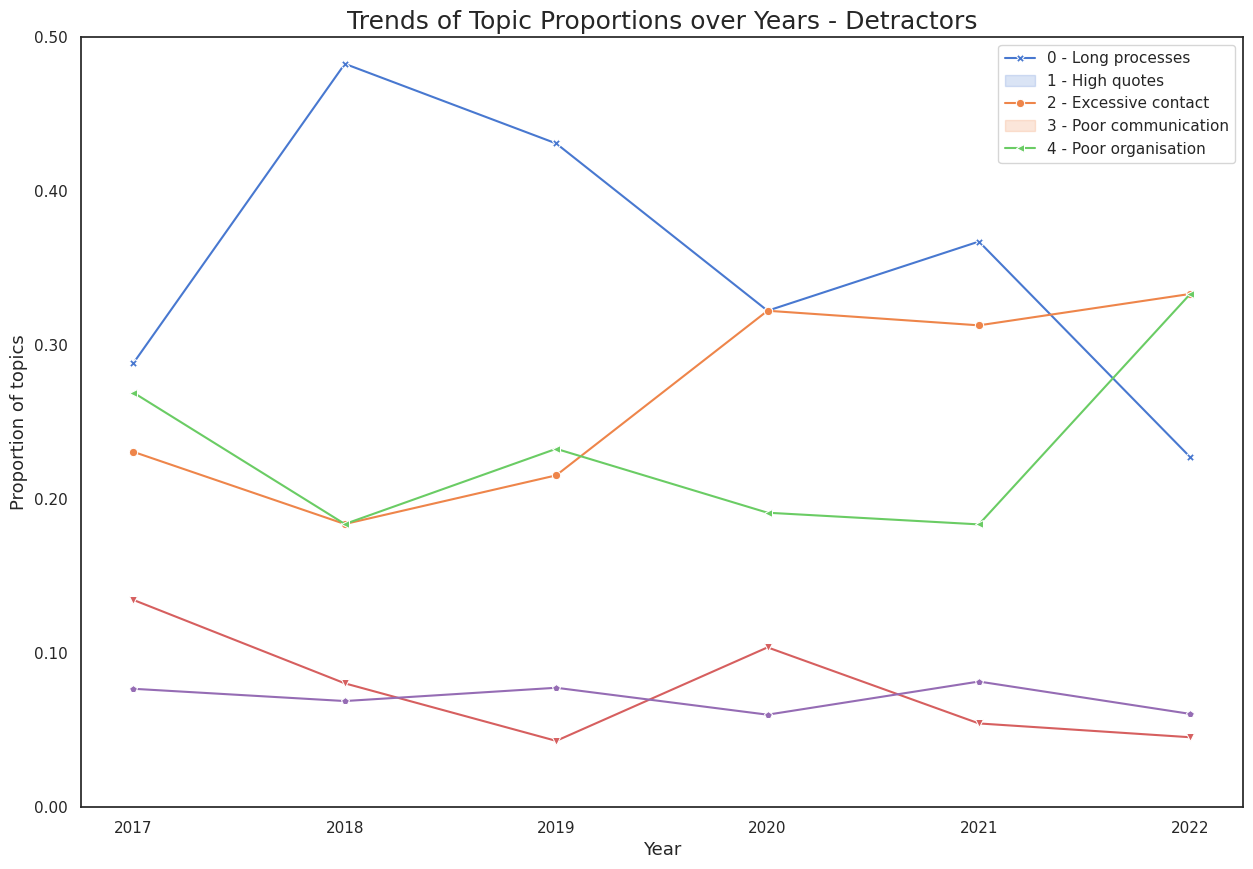

In [87]:
# sns.set_palette("pastel")
sns.set(rc={'figure.figsize':(15,10)}, style='white')

# figure(figsize=(15, 10), dpi=80)

ax = sns.lineplot(x='Timestamp', y='Ratio', hue='Topic', 
             data=df3, palette='muted', style='Topic',markers= ["X", "o","<", "v","p"],  dashes=False)
ax.set_ylabel('Proportion of topics', fontsize=13)
ax.set_xlabel('Year', fontsize=13)
ax.set_ylim(0, 0.5)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

plt.legend(loc='upper right', labels=['0 - Long processes', '1 - High quotes', '2 - Excessive contact', '3 - Poor communication', '4 - Poor organisation'])
plt.title("Trends of Topic Proportions over Years - Detractors", fontsize=18)

## Monthly Trend

In [73]:
det_df = pd.DataFrame({'topic': topics, 'doc_cleaned': det_clean1, 'doc_raw': det["verbatim"], 
                            'year': det['year'],
                            'year-month': det['year-month']})
topic_perc = det_df.groupby(['topic', 'year']).size().groupby(['year']).apply(lambda x: (x/x.sum()))
topic_perc = pd.DataFrame(topic_perc).reset_index().rename(columns={0: "Ratio"})


In [74]:
det_df.topic.value_counts()
det_df = det_df[det_df["topic"]!=-1]

In [75]:
topic_perc = det_df.groupby(['topic', 'year-month']).size().groupby(['year-month']).apply(lambda x: (x/x.sum()))
topic_perc = pd.DataFrame(topic_perc).reset_index().rename(columns={0: "Ratio"})
topic_perc['year-month'] = pd.to_datetime(topic_perc['year-month']).dt.strftime('%Y-%m')
topic_perc = topic_perc.sort_values(by = ["year-month"])

In [76]:
import matplotlib.ticker as ticker


Text(0.5, 1.0, 'Trends of Topic Proportions over Months - Detractors')

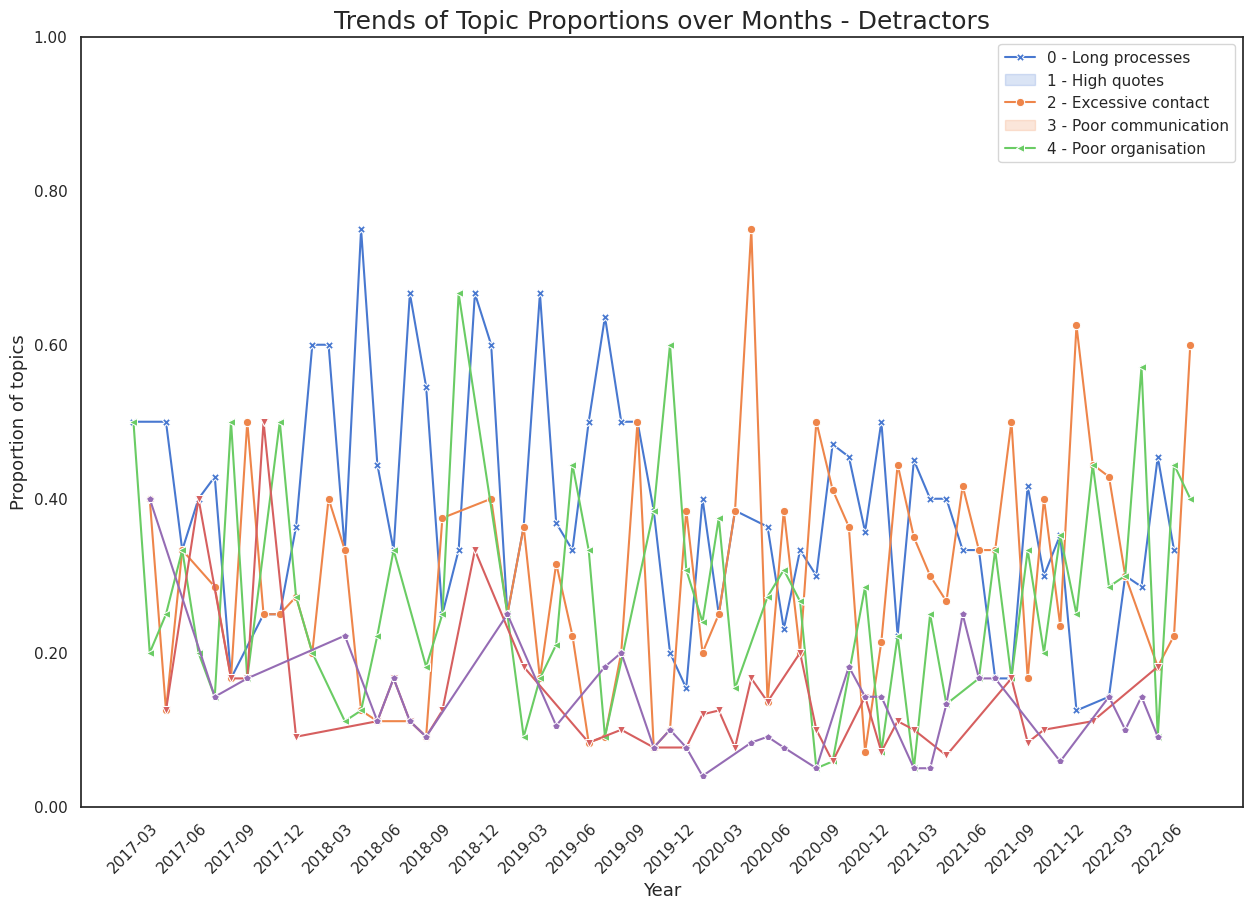

In [78]:
# sns.set_palette("pastel")
sns.set(rc={'figure.figsize':(15,10)}, style='white')

# figure(figsize=(15, 10), dpi=80)

ax = sns.lineplot(x='year-month', y='Ratio', hue='topic', 
             data=topic_perc, palette='muted', style='topic',markers= ["X", "o","<", "v","p"],  dashes=False)
ax.set_ylabel('Proportion of topics', fontsize=13)
ax.set_xlabel('Year', fontsize=13)
ax.set_ylim(0, 1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=3))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

plt.xticks(rotation=45)

plt.legend(loc='upper right', labels=['0 - Long processes', '1 - High quotes', '2 - Excessive contact', '3 - Poor communication', '4 - Poor organisation'])
plt.title("Trends of Topic Proportions over Months - Detractors", fontsize=18)

# New Section